In [1]:
#aitest9 inv
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
from PIL import Image
import os
import scipy.io as sio
import os.path as osp
import glob
import operator
from scipy.io import loadmat
import scipy.misc
import scipy.signal
import scipy.ndimage
from os import listdir
import csv
import cv2
import tensorflow as tf
import torch.nn as nn
from urllib.request import urlopen
from skimage.metrics import structural_similarity
from keras.layers import Concatenate, Flatten
import lpips

import argparse

import copy
import torchvision.transforms as transforms
from tensorflow.keras.models import load_model

# Choose variants here:

In [2]:
arch = 'ResNet50'
num_images =1
trained_model = True

## System setup:

In [3]:
#aitest9
import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')
model1 = torch.nn.Module()
loss_fn, trainloader, validloader = inversefed.construct_dataloaders('ImageNet', defs, data_path='/ImageNet')

model = torchvision.models.resnet50(pretrained=trained_model)
model.to(**setup)

model2 = torchvision.models.resnet50(pretrained=trained_model)
model2.to(**setup)

features = list(model2.children())
if trained_model:
    defs.epochs = 1

model.eval();
model2.eval();
# print(model)

begin
Currently evaluating -------------------------------:
Thursday, 17. August 2023 08:18PM
CPUs: 8, GPUs: 1 on 0d35f8ba2108.
GPU : NVIDIA A100-SXM4-80GB
self.loss_fn = CrossEntropyLoss()


/public/home/aitest9/anaconda3/envs/inv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/public/home/aitest9/anaconda3/envs/inv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
model1.way1 = model2.layer4[2]
model1.pool= torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
model1.cls = torch.nn.Sequential(*features[9:10])
# print(f'model1 = {model1}')

model1.to(**setup) 
model1.eval();

In [5]:
dm = torch.as_tensor(inversefed.consts.nuswide_mean, **setup)[:, None, None] #平均值变成张量
ds = torch.as_tensor(inversefed.consts.nuswide_std, **setup)[:, None, None] #方差变成张量
def plot(tensor):
    tensor = tensor.clone().detach() #复制，不可梯度求导
#     tensor.mul_(ds).add_(dm).clamp_(0, 1) #乘法 加法 赋值得到张量
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu()); #显示图片
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor): # i是元素索引，j是tensor中的元素
            axes[i].imshow(im.permute(1, 2, 0).cpu()); #permute 转置

In [6]:
def clsi_forward(self, x):
        x = x.unsqueeze(-1)
        x = x.unsqueeze(-1)
        x = self.way1(x)
        x = self.pool(x)
        x = x.reshape(x.size(0), -1)
        logits = self.cls(x)
        return logits

# Reconstruct

## Build the input (ground-truth) gradient

In [7]:
ground_truth, labels = [], []
idx =5600 #conch choosen randomly ... just whatever you want
#5300 wombat
#7579  chihuahua 
#20001 academic gown, academic robe, judge’s robe
#27500 espresso maker
gap =100
while len(labels) < num_images:
        img, label = validloader.dataset[idx]
        idx +=gap
#         if label not in labels:
#             labels.append(torch.as_tensor((label,), device=setup['device']))
#             ground_truth.append(img.to(**setup))
        labels.append(torch.as_tensor((label,), device=setup['device']))
        ground_truth.append(img.to(**setup))
ground_truth = torch.stack(ground_truth)
labels = torch.cat(labels)

In [8]:
#aitest9 inv
def grid_plot(tensor, labels):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)

    fig, axes = plt.subplots(1, 2, figsize=(16,16))
    for im, l, ax in zip(tensor, labels, axes.flatten()):
        ax.imshow(im.permute(1, 2, 0).cpu());
        ax.set_title(l)
        ax.axis('off')

tensor([112], device='cuda:0')


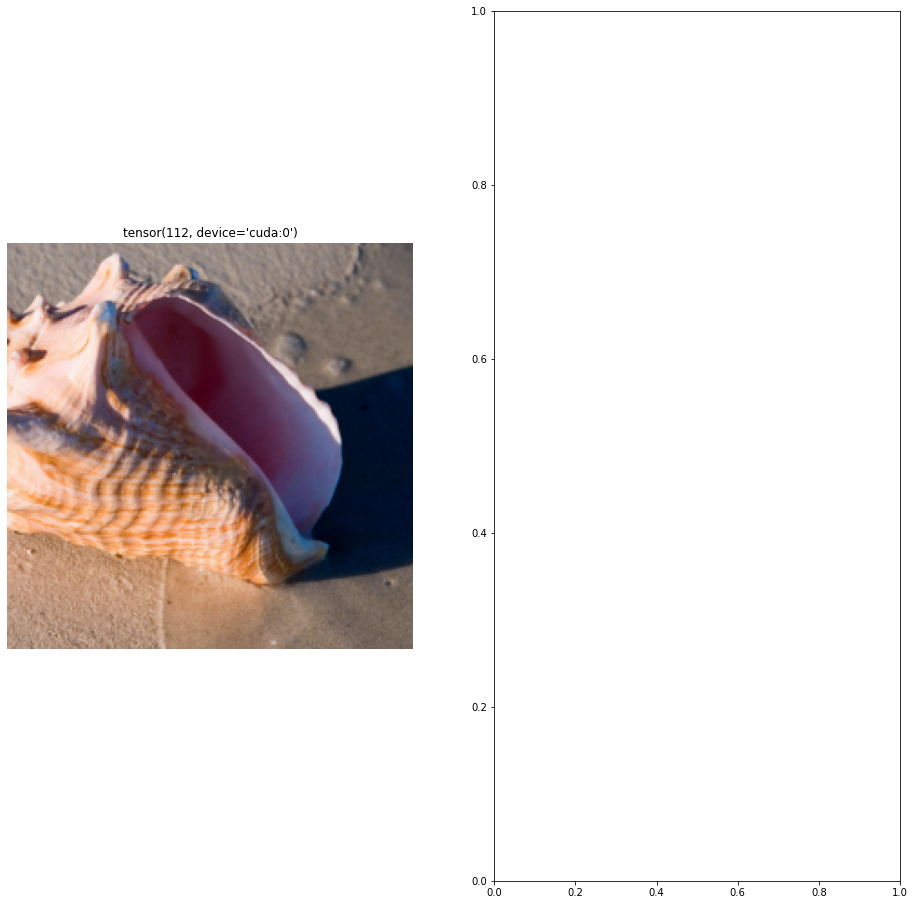

In [9]:
grid_plot(ground_truth, labels);
print(labels);

In [10]:
torchvision.utils.save_image(ground_truth.mul_(ds).add_(dm).clamp(0,1), f'{idx}_input.png')

In [11]:
#aitest9 inv
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
print(target_loss)

input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]

tensor(0.1084, device='cuda:0', grad_fn=<NllLossBackward0>)


# Reconstruct the image

## label rec

In [12]:
 label_ca = []
label_true = []
label_true_G = []
label_GRD=[]
fake_label = []
    
label_input = input_gradient[len(input_gradient)-2]

label_ca= torch.sum(label_input, dim=-1)
label_input1 =torch.argsort (torch.sum(label_input, dim=-1))
    
fake_label1= torch.argsort(
            torch.min(input_gradient[len(input_gradient)-2], dim=-1)[0]
        )[:num_images]
fake_label1 = fake_label1.reshape(num_images)

        
thre =torch.as_tensor((0,), device=setup['device'])


for i in range(num_images):
    if(torch.min(input_gradient[len(input_gradient)-2], dim=-1)[0][fake_label1[i]]<=thre):
        label_true.append(torch.as_tensor((fake_label1[i],), device=setup['device']))

    
label_ca2= torch.sum(label_input, dim=0)
    
fake_gt = []
for i in range(num_images):
    fake_gt.append(label_ca2*10**17)
ground_truth1 = torch.stack(fake_gt)
out_fk = clsi_forward( model1, ground_truth1)
label_fk_sort0 =torch.argsort(out_fk)[0]

k = 0
    
    
for i in range(len(label_fk_sort0)-1):
    if(len(label_true)< num_images):
        if ((out_fk[0][label_fk_sort0[-i-1]] - out_fk[0][label_fk_sort0[-i-2]])//10**10>0.3 and label_fk_sort0[-i-1] in label_true_G):
            label_true.append(label_fk_sort0[-i-1])

for i in range(len(fake_label)):
    if(len(label_true)< num_images):
            label_true.append(fake_label[i])
            
label_true=torch.tensor(label_true).to(**setup)
print(label_true)

tensor([112.], device='cuda:0')


In [13]:
 config = dict(signed=True, 
              boxed=True,
              cost_fn='sim', #累加
              indices='def',
              weights='equal',
              lr=7.5e-3, #学习率
              optim='adam', #优化器
              restarts=1, #？？？
              max_iterations=20_000, #最大迭代数 
              total_variation=1e-1, #总方差
              init='full', #随机初始化
              filter='none', #过滤器
              lr_decay=True,
              scoring_choice='loss',
              alpha_l2 =1e-6)


rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images) #重构一个图片
final_out = []
final_state = {}
final_mse ={}
final_feat_mse = {}
final_ssim={}
final_psnr = {}
final_lpips = {}

ca=[]

In [14]:
lf_LPIPS = lpips.LPIPS(net='alex')
lf_LPIPS.cuda();

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/public/home/aitest9/anaconda3/envs/inv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /public/home/aitest9/anaconda3/envs/inv/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [15]:
img_shape=(3, ground_truth.shape[2], ground_truth.shape[3])
input_gradient1=[]
gr = ground_truth.clone()
a_i=0
psnr_list = []
ssim=[]
ssim_final = 0

output, stats = rec_machine.reconstruct(input_gradient, label_true, input_gradient1, a_i, ca, gr, img_shape)
final_out.append(output.clone())
output1 = output.clone()
max_out = torch.max(torch.tensor(output1))
input_gradient1= output1.expand(config['restarts'], num_images, img_shape[0], img_shape[1], img_shape[2])

im = output1.mul(255).byte()
im = im.cpu().numpy().transpose(0, 2, 3, 1)

output2 = im
im1 = ground_truth.mul(255).byte()

im2 = im1.cpu().numpy().transpose(0, 2, 3, 1)
ground_truth_2 = im2    


for j in range(output2.shape[0]):
        ssim .append( structural_similarity(output2[j], ground_truth_2[j], full=True, channel_axis =2)[0])     

for i in range(len(ssim)):
    ssim_final =ssim_final+ ssim[i]
ssim_final = ssim_final / len(ssim)
    
test_mse = (output1.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output1.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output1, ground_truth, False, max_out)
    
lpips = lf_LPIPS.forward(output1,ground_truth)
    
final_state = stats['opt']
final_mse = test_mse
final_feat_mse = feat_mse
final_psnr = test_psnr
final_ssim = ssim_final
final_lpips = lpips

start
times1=0
x.shape=torch.Size([1, 1, 3, 224, 224])
change = 13333.0
It: 0. Rec. loss: 1.0518.
It: 3000. Rec. loss: 0.3699.
It: 6000. Rec. loss: 0.3778.
It: 9000. Rec. loss: 0.3553.
It: 12000. Rec. loss: 0.3580.
It: 15000. Rec. loss: 0.2486.
It: 18000. Rec. loss: 0.2495.
It: 19999. Rec. loss: 0.2450.
min value = 0.22536180913448334
min value site = 19843
Choosing optimal result ...
Optimal result score: 0.2260 in 0 round
Total time: 1705.1759889125824.


<ipython-input-15-a4a3c9904f05>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_out = torch.max(torch.tensor(output1))


Rec. loss: 0.2260 | MSE: 0.0955 | PSNR: 17.97 | FMSE: 9.2684e-01 |SSIM:0.08135460457047222|LPIPS:0.48677200078964233


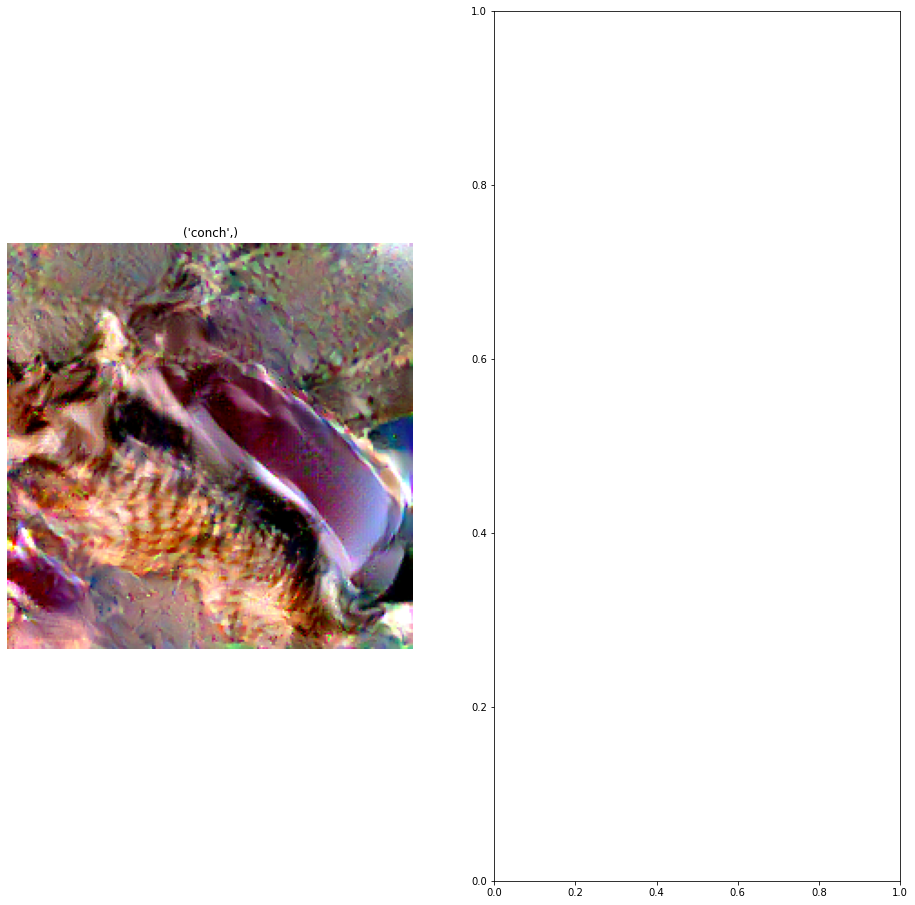

In [16]:
#test9
grid_plot(output.sub(dm).div(ds), [validloader.dataset.classes[l] for l in labels]);
print(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
      f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |SSIM:{final_ssim}|LPIPS:{final_lpips.mean()}");

In [17]:
output_denormalized = torch.clamp(output1, 0, 1)
torchvision.utils.save_image(output_denormalized, f'final_{idx}+{gap}_{arch}_bs=1-7.5e-3-GIT-1.png')